In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [2]:
os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv','train.csv')

'jigsaw-toxic-comment-classification-challenge\\train.csv\\train.csv'

In [3]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv','train.csv'))

In [4]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
df.iloc[32]['comment_text']

'Praise \n\nlooked at this article about 6 months ago -much improved. ]'

In [8]:
df[df.columns[2:]].iloc[32]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 32, dtype: int64

In [9]:
# Preprocessing 

from tensorflow.keras.layers import TextVectorization

In [10]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [12]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [13]:
MAX_FEATURES = 200000 #number of words in the vocabulary

In [14]:
vectorizer = TextVectorization(max_tokens = MAX_FEATURES, output_sequence_length = 1800, output_mode = 'int')

In [15]:
# making textvectorizer adapt to the vocab
vectorizer.adapt(X.values)

In [16]:
vectorizer('Hello world')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([286, 261,   0, ...,   0,   0,   0], dtype=int64)>

In [17]:
vectorized_text = vectorizer(X.values)

In [18]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  643,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2506, ...,     0,     0,     0],
       [  425,   440,    70, ...,     0,     0,     0],
       ...,
       [32141,  7329,   383, ...,     0,     0,     0],
       [    5,    12,   533, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]], dtype=int64)>

In [19]:
# creating tensorflow data pipeline
# MCSHBAP - map, cache, shuffle, batch, prefetch from_tensor_slices or list_file

dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) #helps prevent bottlenecks

In [23]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [25]:
batch_X.shape

(16, 1800)

In [26]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [27]:
train_generator = train.as_numpy_iterator()

In [29]:
train_generator.next()

(array([[   386,      2,   5881, ...,      0,      0,      0],
        [    38,     43,      6, ...,      0,      0,      0],
        [   317,   5401,     52, ...,      0,      0,      0],
        ...,
        [  9645,   1049,    220, ...,      0,      0,      0],
        [   715, 142447,   5883, ...,      0,      0,      0],
        [    48,   7077,     54, ...,      0,      0,      0]], dtype=int64),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]], dtype=int64))

In [31]:
# Creating sequential model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding #layers need to build deep neural network

model = Sequential()
# first creating the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# second layer Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer (this layer maps to the number of outputs in neural networks)
model.add(Dense(6, activation='sigmoid')) #sigmoid converts output in betweenof 0 and 1 

In [32]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [34]:
history = model.fit(train, epochs=1, validation_data=val)

6981/6981 [==============================] - 6624s 949ms/step - loss: 0.0638 - val_loss: 0.0449


In [37]:

from matplotlib import pyplot as plt

history.history

{'loss': [0.06383897364139557], 'val_loss': [0.04487932100892067]}

<Figure size 576x360 with 0 Axes>

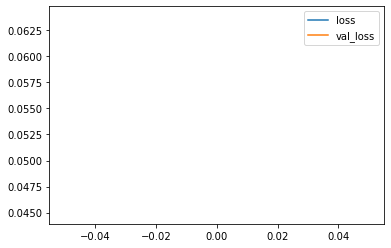

In [38]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# to get a graph run at least epoch=5 or 6 to get points

In [55]:
# making predictions

input_text = vectorizer('You freaking suck! I am going to hit you.')
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 7113,  396, ...,    0,    0,    0], dtype=int64)>

In [56]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [57]:
batch = test.as_numpy_iterator().next()

In [58]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [59]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 0s 133ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [65]:
res = model.predict(batch_X)

1/1 [==============================] - 0s 141ms/step


In [66]:
# Evaluating our model usinf precision recall

from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [67]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [68]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 148ms/step


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 143ms/step


1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - 0s 185ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 141ms/step


In [69]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8872312307357788, Recall:0.5757403373718262, Accuracy:0.48345035314559937


In [72]:
import tensorflow as tf
import gradio as gr

In [73]:
model.save('chat-toxicity.h5')

In [74]:
model = tf.keras.models.load_model('chat-toxicity.h5')

In [81]:
input_str = vectorizer('hey I hate you! I will kill you')

In [82]:
res = model.predict(np.expand_dims(input_str,0))

1/1 [==============================] - 0s 71ms/step


In [83]:
res

array([[0.7131408 , 0.0203852 , 0.32624495, 0.03506006, 0.35833696,
        0.06628177]], dtype=float32)

In [84]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [86]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Write some Comment'),
                        outputs='text')

In [89]:
interface.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Running on local URL:  http://127.0.0.1:7860

Could not create share link, please check your internet connection.
